## 0. Load and set up

In [2]:
import torch
import matplotlib.pyplot as plt
from utils._experiment import berkenkamp_1d
from utils._gp import set_gp, normalise
from utils._batch_query import landmark_points, batch_query, query_and_update
from utils._prior import Uniform

def visualise(train_X, train_Y, test_X, test_Y, gp):
    pred = gp.likelihood(gp(test_X))
    mean, stddev = pred.mean, pred.stddev
    
    plt.plot(test_X, normalise(test_Y, train_Y), color="k", linestyle="--")
    plt.scatter(train_X, normalise(train_Y, train_Y), color="k", label="observed")
    plt.plot(test_X, mean.detach(), color="b")
    plt.fill_between(
        test_X.squeeze(),
        (mean + stddev).detach(),
        (mean - stddev).detach(),
        color="b",
        alpha=0.3,
    )
    print(f"The total predictive uncertainty: {stddev.sum().item()}")
    return stddev.sum().item()

## 1. Initial setup and hyperparameters

In [4]:
### Hyperparameters
# Condition: n_cand >> n_nys >= batch_size
n_cand = 20000 # number of random candidate points
n_nys = 100    # number of landmark points for Nyström approximation

# Define the domain
torch.manual_seed(42)
bound = torch.tensor([[0],[1]])
prior = Uniform(bound)

# Generate initial samples and test points
train_X = torch.tensor([0, 0.05, 0.4, 1]).unsqueeze(-1)
train_Y = berkenkamp_1d(train_X).unsqueeze(-1)
test_X = torch.linspace(0,1,1000).unsqueeze(-1)
test_Y = berkenkamp_1d(test_X)

# Supersamples for kernel quadrature
X_cand = prior.sample(n_cand)
X_nys = landmark_points(X_cand, n_nys)

## 2. Try out adaptive batch size (AdaBatAl)

The total predictive uncertainty: 513.8274536132812
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-31


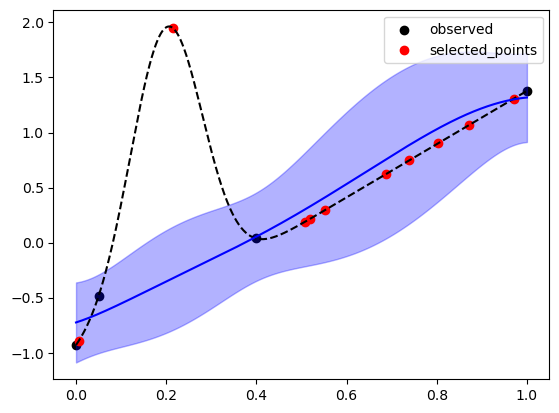

Actually queried batch samples: 10
The total predictive uncertainty: 83.24363708496094


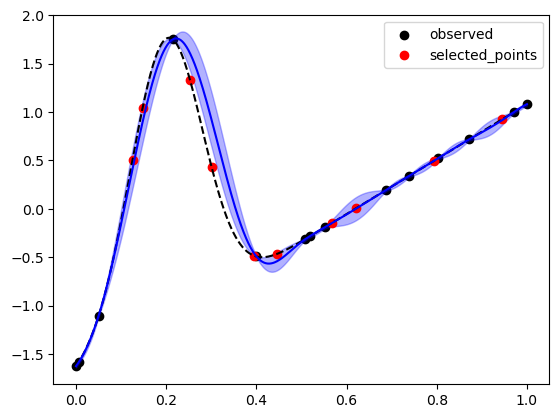

Actually queried batch samples: 10
The total predictive uncertainty: 22.628934860229492


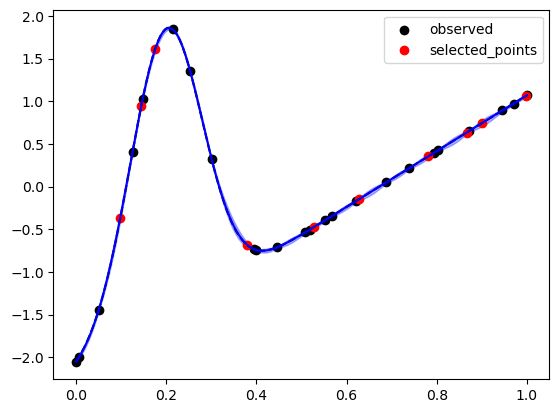

Actually queried batch samples: 10
The total predictive uncertainty: 16.222009658813477


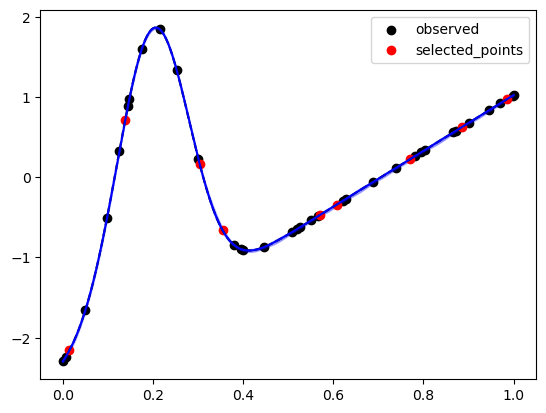

Actually queried batch samples: 9
The total predictive uncertainty: 15.336990356445312


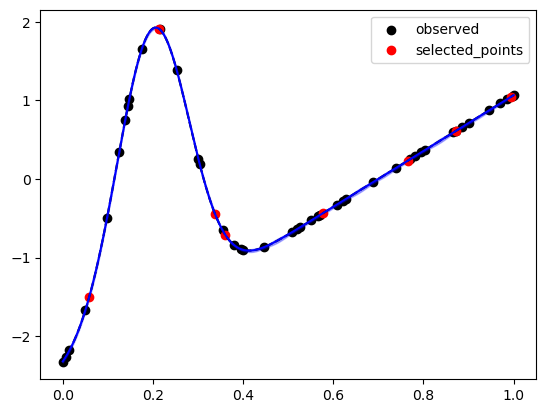

Actually queried batch samples: 8
The total predictive uncertainty: 14.719273567199707


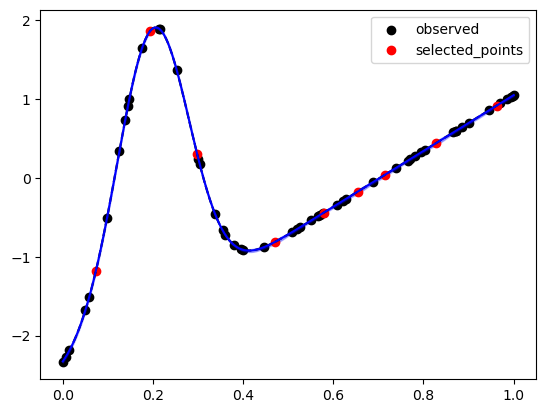

Actually queried batch samples: 9
The total predictive uncertainty: 13.12291145324707


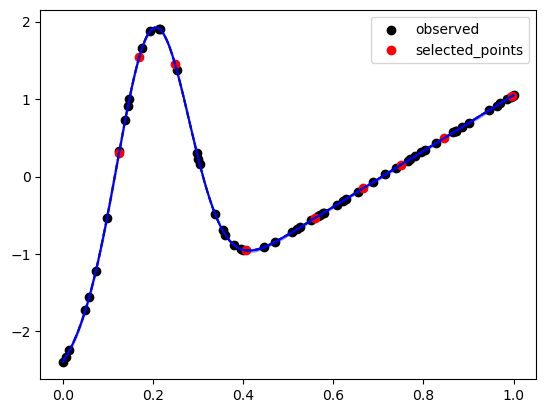

Actually queried batch samples: 9
The total predictive uncertainty: 12.818744659423828


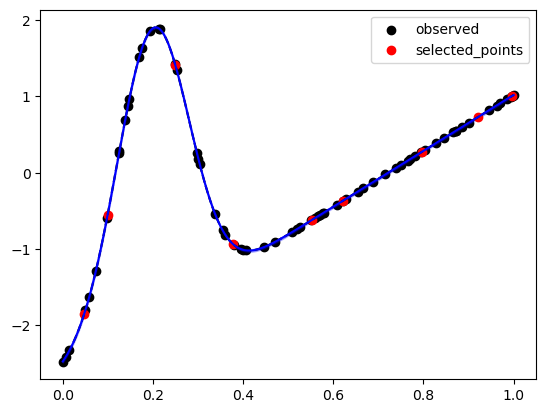

Actually queried batch samples: 9
The total predictive uncertainty: 12.511211395263672


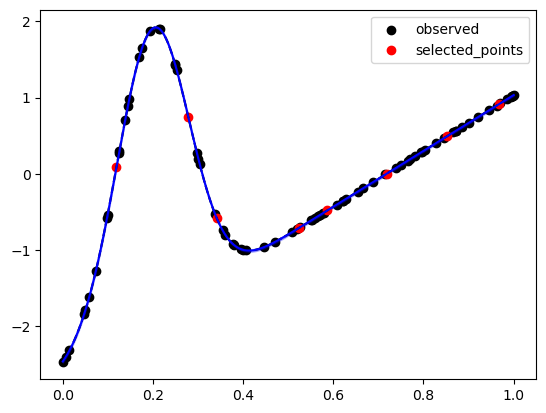

Actually queried batch samples: 8
The total predictive uncertainty: 12.243477821350098


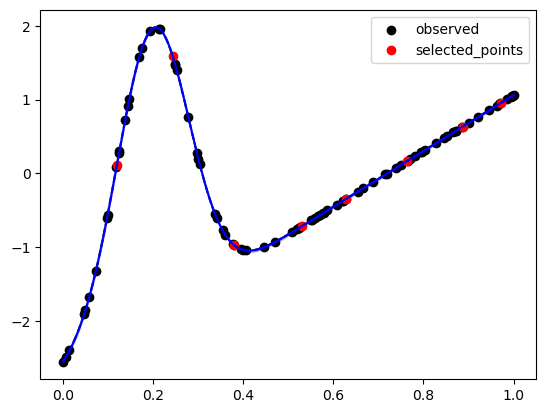

Actually queried batch samples: 8


In [6]:
# try out changing tolerance and how the results changes
fixed_batch=False # Adaptive batch size or fixed batch size
batch_size = 10   # Max batch sizes to query
tolerance = 0.4  # 1e-8 is almost exact computation (~fixed batch size). Larger adapts batch size more aggresively.

results = []
for i in range(10):
    gp = set_gp(train_X, train_Y)
    stddev = visualise(train_X, train_Y, test_X, test_Y, gp)
    X_new = batch_query(gp, X_cand, X_nys, batch_size=batch_size, tolerance=tolerance, fixed_batch=fixed_batch)
    train_X, _train_Y, X_new, Y_new = query_and_update(train_X, train_Y, X_new, berkenkamp_1d)
    plt.scatter(X_new, normalise(Y_new, train_Y), color="r", label="selected_points")
    plt.legend()
    plt.show()
    train_Y = _train_Y
    print(f"Actually queried batch samples: {len(X_new)}")
    results.append([len(X_new), stddev])
results = torch.tensor(results)

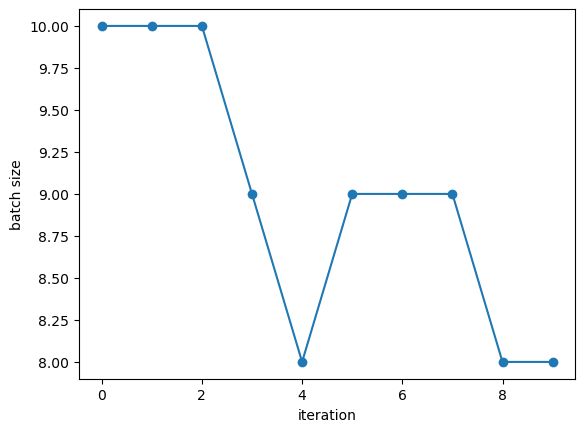

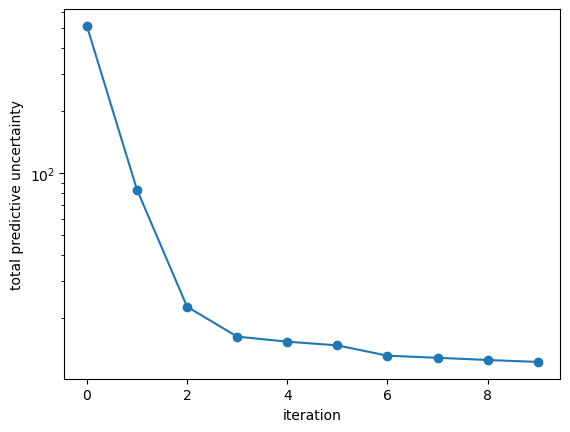

In [7]:
plt.plot(results[:,0], "-o")
plt.xlabel("iteration")
plt.ylabel("batch size")
plt.show()

plt.plot(results[:,1], "-o")
plt.xlabel("iteration")
plt.ylabel("total predictive uncertainty")
plt.yscale("log")